# Antihistamine Resistance Prediction

### Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'pandas'

## Loading the Dataset





In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/IOMP /antihistamine_resistance_dataset.csv')

In [5]:
print(("Dataset"))
print(df.head())

print(("\nInfo On Dataset"))
print(df.info())


Dataset
   Age  Gender Allergy_Type  Duration_Allergy Antihistamine_Type  \
0   34    Male     Seasonal                70            2nd_gen   
1   46    Male         Drug                34            1st_gen   
2   66  Female         Drug                94            2nd_gen   
3   66    Male        Other               229            2nd_gen   
4   54  Female         Drug               134            2nd_gen   

  Co_morbidities Previous_Use  Response  
0         Eczema   Short_term         0  
1         Eczema   Short_term         0  
2         Eczema    Long_term         1  
3            NaN   Short_term         0  
4         Eczema    Long_term         1  

Info On Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 1000 non-null   int64 
 1   Gender              1000 non-null   object
 2   Allergy_Type

## **Cleaning and Preprocessing**

### 1. Handle Missing Values

In [6]:
# Impute categorical columns with median
for col in ['Age', 'Duration_Allergy', 'Response']:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

In [7]:
# Impute categorical columns with mode
for col in ['Gender', 'Co_morbidities']:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)

### 2. Clean Inconsistent Formatting

In [8]:
categorical_cols = ['Gender', 'Allergy_Type', 'Antihistamine_Type', 'Co_morbidities', 'Previous_Use']
for col in categorical_cols:
    # Strip whitespace
    df[col] = df[col].astype(str).str.strip()
    # Convert to consistent case (e.g., title case for some, lowercase for others)
    if col in ['Gender', 'Allergy_Type']:
        df[col] = df[col].str.title()
    else:
        df[col] = df[col].str.lower()

In [9]:
# Standardize values for Gender
df['Gender'] = df['Gender'].replace({'M': 'Male', 'F': 'Female', 'M ': 'Male', 'F ': 'Female', 'FEMALE': 'Female', 'male': 'Male'})


### 3. Handling outliers

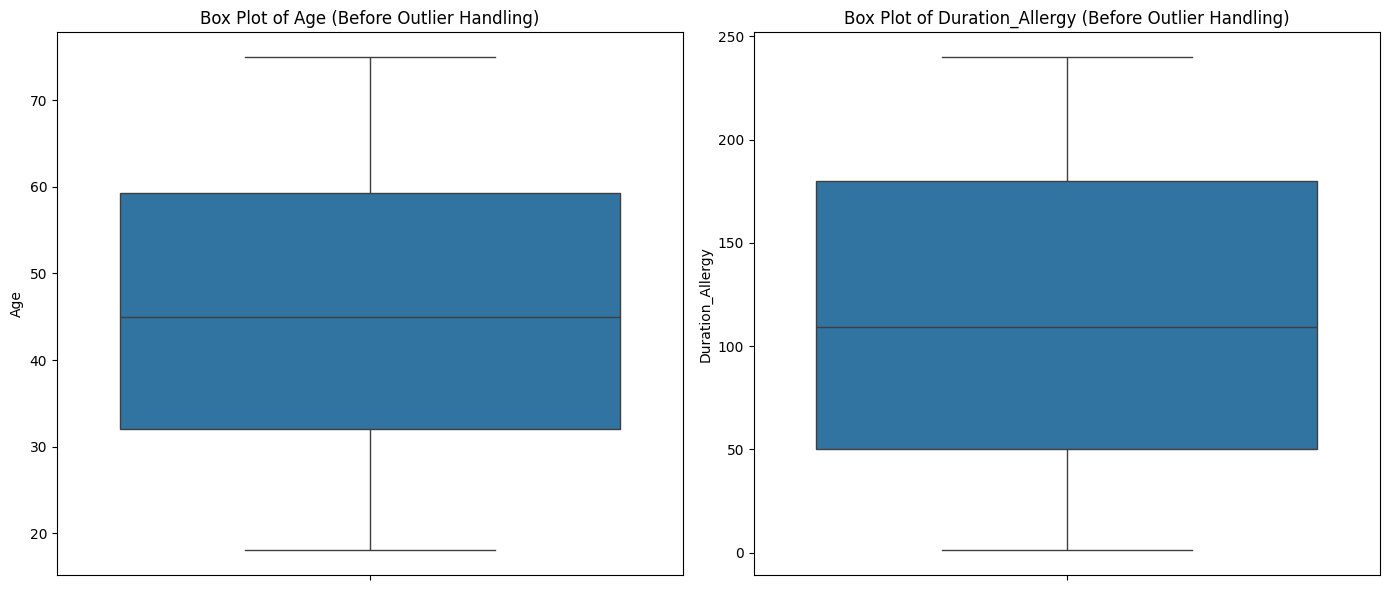

In [10]:
# Box plot for 'Age'
# Box plot for 'Age' and 'Duration_Allergy' (Before Outlier Handling)
numerical_cols_for_outliers = ['Age', 'Duration_Allergy']

plt.figure(figsize=(14, 6))
for i, col in enumerate(numerical_cols_for_outliers):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col} (Before Outlier Handling)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [11]:
#Handling outliers
# Age: Cap extreme values
df['Age'] = np.where(df['Age'] < 0, 0, df['Age'])
df['Age'] = np.where(df['Age'] > 100, 100, df['Age'])

In [12]:
# Duration_Allergy: Cap extreme values
df['Duration_Allergy'] = np.where(df['Duration_Allergy'] < 0, 0, df['Duration_Allergy'])
df['Duration_Allergy'] = np.where(df['Duration_Allergy'] > 365, 365, df['Duration_Allergy'])


In [13]:

# Response: Ensure values are 0 or 1
df['Response'] = df['Response'].apply(lambda x: 1 if x in [1.0, 10.0] else 0)

In [14]:
df = df[(df['Age'] >= 18) & (df['Duration_Allergy'] <= 250)]

In [15]:

# Convert numerical columns to integer type
df['Age'] = df['Age'].astype(int)
df['Duration_Allergy'] = df['Duration_Allergy'].astype(int)
df['Response'] = df['Response'].astype(int)

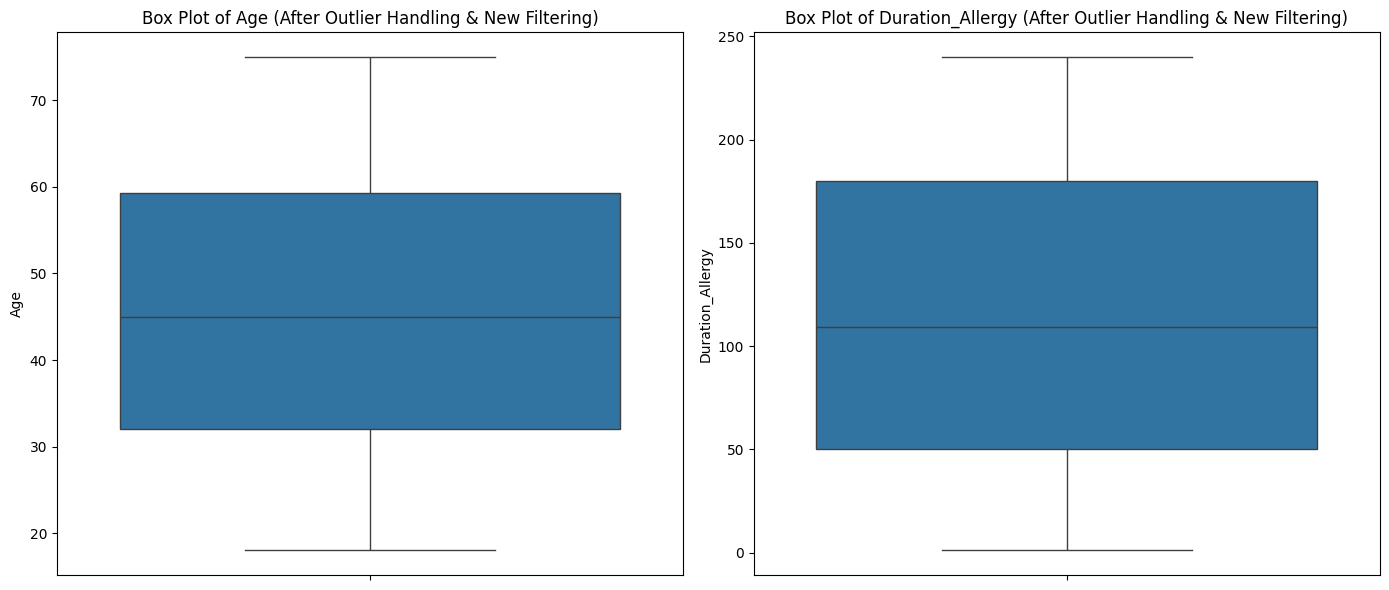

In [16]:
# Box plot for 'Age' and 'Duration_Allergy' (After Outlier Handling and New Filtering)
plt.figure(figsize=(14, 6))
for i, col in enumerate(numerical_cols_for_outliers):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col} (After Outlier Handling & New Filtering)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

### 4. Remove duplicate rows

In [17]:

df_cleaned = df.drop_duplicates().copy()


In [18]:

print(("Cleaned Dataset"))
print(df_cleaned.head())

print(("\nInfo On Cleaned Dataset"))
print(df_cleaned.info())

Cleaned Dataset
   Age  Gender Allergy_Type  Duration_Allergy Antihistamine_Type  \
0   34    Male     Seasonal                70            2nd_gen   
1   46    Male         Drug                34            1st_gen   
2   66  Female         Drug                94            2nd_gen   
3   66    Male        Other               229            2nd_gen   
4   54  Female         Drug               134            2nd_gen   

  Co_morbidities Previous_Use  Response  
0         eczema   short_term         0  
1         eczema   short_term         0  
2         eczema    long_term         1  
3         eczema   short_term         0  
4         eczema    long_term         1  

Info On Cleaned Dataset
<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 0 to 931
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 285 non-null    int64 
 1   Gender              285 non-null    object
 2   Al

In [19]:
#Output Counts
print("\nClass distribution:\n", df_cleaned['Response'].value_counts())


Class distribution:
 Response
1    227
0     58
Name: count, dtype: int64


###  Scatter Plot

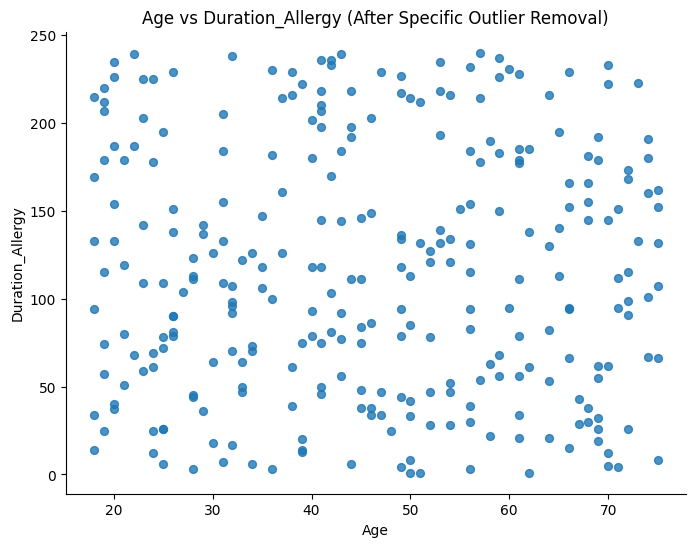

In [20]:
#Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned['Age'], df_cleaned['Duration_Allergy'], s=32, alpha=.8)
plt.title('Age vs Duration_Allergy (After Specific Outlier Removal)')
plt.xlabel('Age')
plt.ylabel('Duration_Allergy')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()

# **Data Visualization**


Here, We visualize the data through the use of various visualization techniques such as heat maps etc.



### Violin Plot

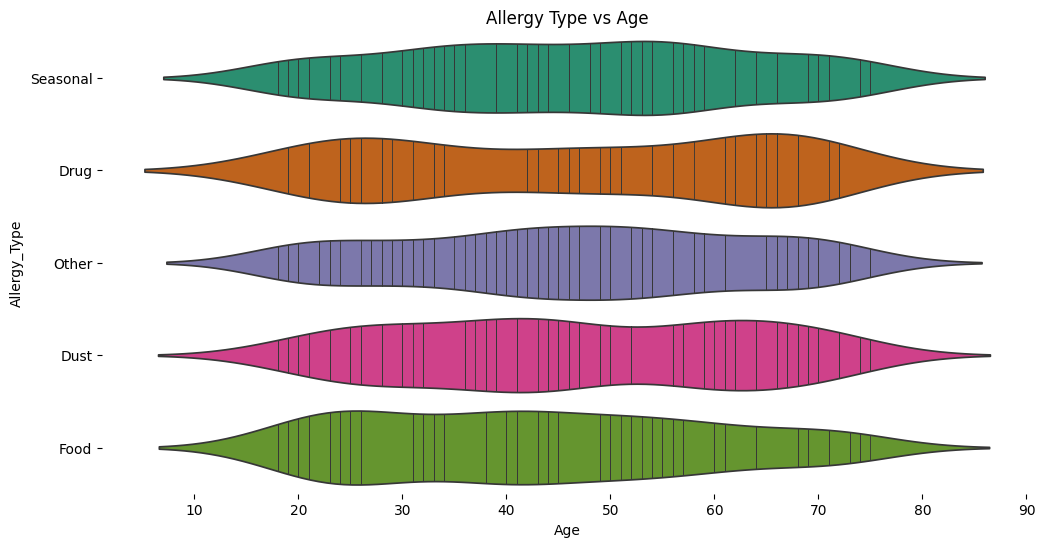

In [21]:
figsize = (12, 1.2 * len(df['Allergy_Type'].unique()))
plt.figure(figsize=figsize)
plt.title('Allergy Type vs Age')
sns.violinplot(df, x='Age', y='Allergy_Type', hue='Allergy_Type', inner='stick', palette='Dark2', legend=False)
sns.despine(top=True, right=True, bottom=True, left=True)

### Heatmap

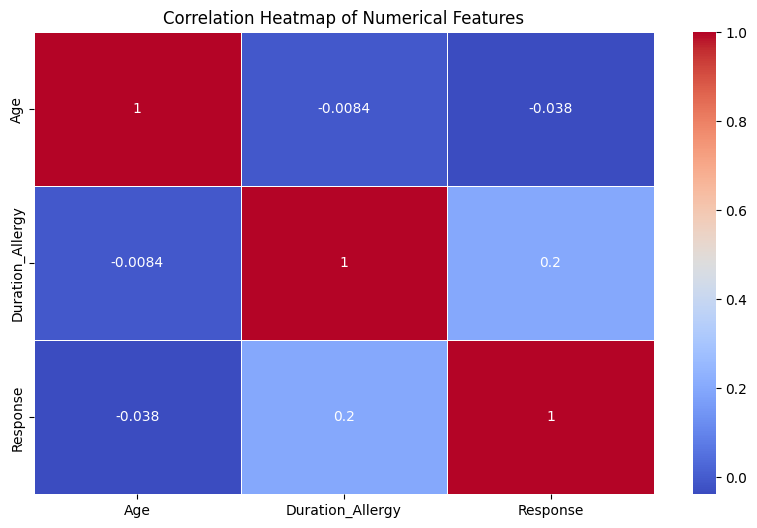

In [22]:

numeric_df = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

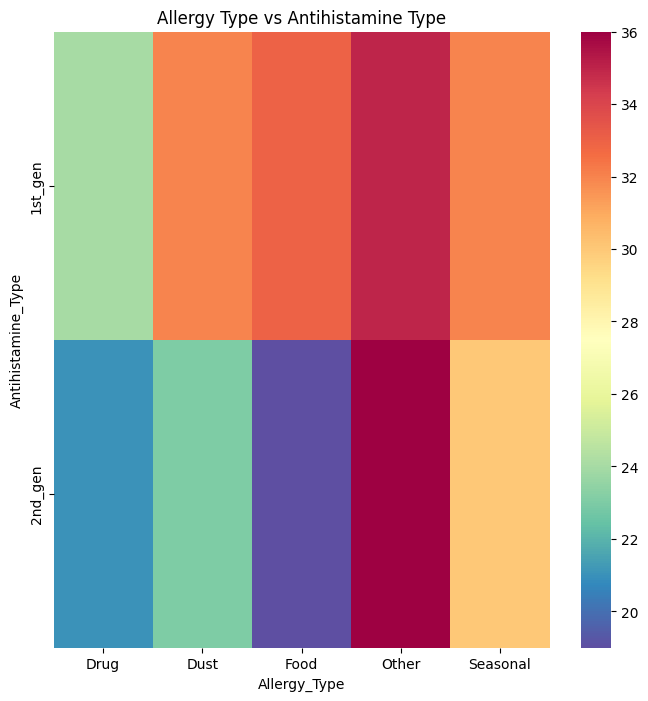

In [23]:
#  Allergy_Type vs Antihistamine_Type

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Antihistamine_Type'].value_counts()
    for x_label, grp in df_cleaned.groupby('Allergy_Type')
})
sns.heatmap(df_2dhist, cmap='Spectral_r')
plt.xlabel('Allergy_Type')
plt.title('Allergy Type vs Antihistamine Type')
_ = plt.ylabel('Antihistamine_Type')



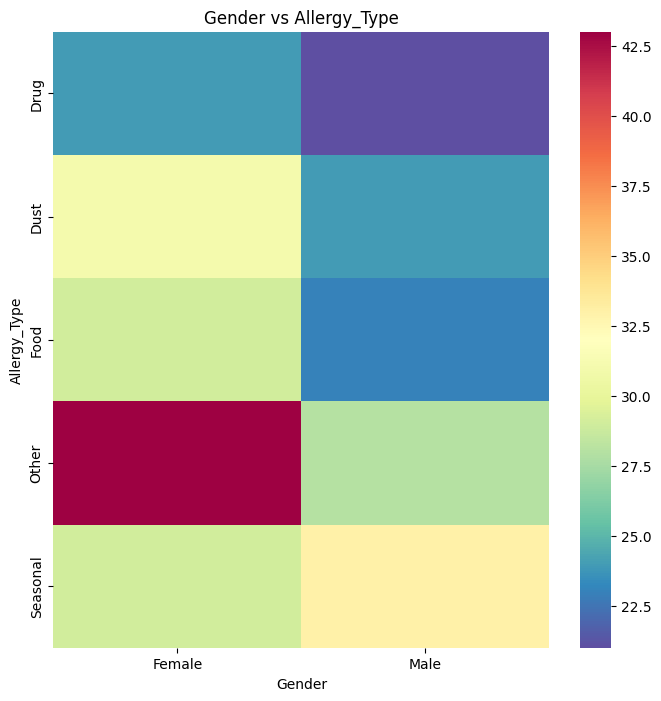

In [24]:
# @title Gender vs Allergy_Type

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Allergy_Type'].value_counts()
    for x_label, grp in df_cleaned.groupby('Gender')
})
sns.heatmap(df_2dhist, cmap='Spectral_r')
plt.title('Gender vs Allergy_Type')
plt.xlabel('Gender')
_ = plt.ylabel('Allergy_Type')

## Preprocessing

In [25]:
# Prepare data for Logistic Regression
X = df_cleaned.drop('Response', axis=1)
y = df_cleaned['Response']

In [26]:
# Define numerical and categorical features
numerical_features = ['Age', 'Duration_Allergy']
categorical_features = ['Gender', 'Allergy_Type', 'Antihistamine_Type', 'Co_morbidities', 'Previous_Use']

In [27]:
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [28]:
# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

## Training ML Model

### Using Logistic Regression

In [29]:
# Create instances of the base models
# Using 'liblinear' solver for LogisticRegression is good for small datasets
clf1 = LogisticRegression(solver='liblinear', random_state=42)

# RandomForestClassifier is great for non-linear relationships
# n_estimators is the number of trees in the forest
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

# XGBoostClassifier is a powerful, high-performance gradient boosting model
# The 'eval_metric' and 'use_label_encoder' parameters are for compatibility and to silence warnings
clf3 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Create the Soft Voting Classifier
# The 'estimators' list contains the models to be ensembled
# The 'voting'='soft' parameter averages the predicted probabilities
# 'weights' can be used to give more importance to specific models (adjust as needed)
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft', weights=[0.2, 0.4, 0.4])

# Update the main pipeline to use the VotingClassifier instead of a single model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', eclf1)])

In [30]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
# Train the model
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:36:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'Duration_Allergy']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Allergy_Type',
                                                   'Antihistamine_Type',
                                                   'Co_morbidities',
                                                   'Previous_Use'])])),
                ('classifier',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(random_state=...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None, ...))],
                                  voting='soft', weights=[0.2, 0.4, 0.4]))])

## Evaluating the ML Model

In [32]:

# Make predictions on the test set
y_pred = model.predict(X_test)

In [33]:
# Evaluate the model
print("\nLogistic Regression Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression Model Performance:
Accuracy: 0.9824561403508771

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.98      1.00      0.99        45

    accuracy                           0.98        57
   macro avg       0.99      0.96      0.97        57
weighted avg       0.98      0.98      0.98        57


Confusion Matrix:
 [[11  1]
 [ 0 45]]


In [35]:
# Print accuracy
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Accuracy Score: 0.9824561403508771


## Testing Custom Output

In [36]:
# Function to predict resistance for new input
def predict_resistance(model, new_input_data):

    # Create a DataFrame from the new input data
    new_df = pd.DataFrame([new_input_data])

    # Ensure the new_df has all the columns from the original training data's features (X)
    # and in the same order. Fill missing columns with appropriate defaults (e.g., mode for categorical, median for numerical)
    for col in X.columns:
        if col not in new_df.columns:
            if col in numerical_features:
                new_df[col] = X[col].median()
            elif col in categorical_features:
                new_df[col] = X[col].mode()[0]
            else:
                new_df[col] = None

    # Reorder columns to match the training data
    new_df = new_df[X.columns]

    # Make prediction
    prediction = model.predict(new_df)
    return prediction[0]


In [37]:
# Example of predicting with a new input:
print("\n--- Example Prediction for New Input ---")
new_patient_data = {
    'Age': 30,
    'Gender': 'Female',
    'Allergy_Type': 'Dust',
    'Duration_Allergy': 60,
    'Antihistamine_Type': '2nd_gen',
    'Co_morbidities': 'None',
    'Previous_Use': 'short_term'
}
print(f"Predicted resistance for the new patient: {predict_resistance(model, new_patient_data)}")



--- Example Prediction for New Input ---
Predicted resistance for the new patient: 1


In [38]:
# Another example
print("\n--- Another Example Prediction for New Input ---")
new_patient_data_2 = {
    'Age': 55,
    'Gender': 'Male',
    'Allergy_Type': 'Pollen',
    'Duration_Allergy': 200,
    'Antihistamine_Type': '1st_gen',
    'Co_morbidities': 'Asthma',
    'Previous_Use': 'long_term'
}
print(f"Predicted resistance for the new patient: {predict_resistance(model, new_patient_data_2)}")


--- Another Example Prediction for New Input ---
Predicted resistance for the new patient: 1


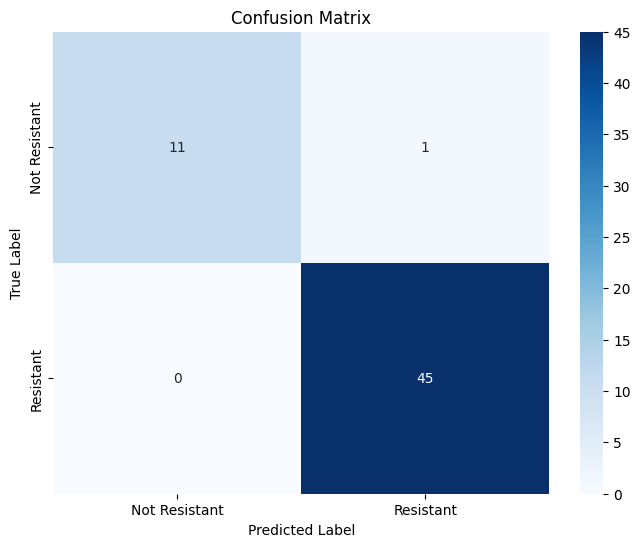

In [39]:
# Plotting the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Resistant", "Resistant"],
            yticklabels=["Not Resistant", "Resistant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(
    "Confusion Matrix")
plt.show()